In [1]:
from _plotly_future_ import v4_subplots
from plotly.subplots import make_subplots


import pandas as pd
pd.set_option("display.max_rows", 1500)
pd.set_option("display.max_columns", 1000)
import numpy as np
import scipy as scp
import scipy.stats as ss
import sklearn.metrics as sm

from scipy.integrate import quad
import matplotlib.pyplot as plt

import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
from scipy.optimize import minimize, brute, fmin
from IPython.display import display
import sympy; sympy.init_printing()
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


def display_matrix(m):
    display(sympy.Matrix(m))

## Pricing Function

The [Heston process](https://en.wikipedia.org/wiki/Heston_model) is described by the SDE: 

$ \begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t 
\end{cases}$

The stock price follows a "geometric Brownian motion" with a stochastic volatility. The square of the volatility (the variance) follows a CIR process.     

Parameters from the market are:
- $\mu$ drift of the stock process
- $S_t$ price of the underlying asset

Parameters to be calibrated are:
- $v_t$ the instantaneous variance from the second equation 
- $\kappa$ mean reversion coefficient of the variance process
- $\theta$ long term mean of the variance process 
- $\sigma$  volatility coefficient of the variance process
- $\rho$ correlation between $W^1$ and $W^2$ i.e.
$$ dW^1_t dW^2_t = \rho dt $$

We will also require that $2\kappa \theta > \sigma^2$ (Feller condition).




From paper Carr and Mad
The risk neural probability of finishing in-the-money is:
$
\mathbb{P}(S_T > K) = \Pi_2 = 1/2 + 1/\pi \int_0^\infty \operatorname{Re}(\frac{\operatorname{e}^{-iu \operatorname{ln}(K)}\phi_T(u)}
{iu}
)du
$ 

where the characteristic function suggested by Schoutens
$
\phi(u,t) = E[exp(iu \operatorname{log}(S_t))|S_0, v_0] \\
\qquad \ = \operatorname{exp}(iu(\operatorname{log}S_0 + (r-q)t)) \\
\qquad \;  \times \operatorname{exp}(\theta\kappa\sigma^{-2}((\kappa - \rho \sigma u i -d)t - 2 \operatorname{log}((1-g \operatorname{e}^{-dt})/(1-g)))) \\
\qquad \; \times \operatorname{exp}(v_0 \sigma^{-2}(\kappa - \rho \sigma u i -d)(1-\operatorname{e}^{-dt})/(1-g\operatorname{e}^{-dt}))
$

and
$
d = ((\rho \sigma u i - \kappa)^2 - \theta^2(-iu-u^2))^{\frac{1}{2}} \\
g = (\kappa - \rho \sigma u i - d) / (\kappa - \rho \sigma u i + d)
$

notes: $\mu=r-q$ in the codes below

The delta of the option, dnoted by $\Pi_1$, is numerically obtained as:
$
\Delta = \Pi_1 = 1/2 + 1/\pi \int_0^\infty \operatorname{Re}(\frac{\operatorname{e}^{-iu \operatorname{ln}(K)}\phi_T(u-i)}
{iu\phi_T(-i)}
)du
$

Withour dividends and with constant interest rates $r$, the initial option value is:
$
C = S\Pi_1 - K\operatorname{e}^{-rT}\Pi_2
$

In [2]:
def cf_Heston_schoutens(u, S0, t, mu, v0, kappa, theta, rho, sigma):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma*rho*u*1j
    d  = np.sqrt( xi**2 + sigma**2 * (u**2 + 1j*u) )
    g  = (xi-d)/(xi+d)
    
    cf = np.exp((1j*u)*(np.log(S0)+mu*t)) * \
         np.exp((kappa*theta)/(sigma**2) * ( (xi-d)*t - 2*np.log( (1-g*np.exp(-d*t))/(1-g) ))) *\
         np.exp((v0/sigma**2)*(xi-d) * (1-np.exp(-d*t))/(1-g*np.exp(-d*t)) )
    return cf

In [3]:
def Q1(K, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the stock numeraire.
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( (np.exp(-u*np.log(K)*1j) / (u*1j)) * 
                                  cf(u=u-1j) / cf(u=-1.0000000000001j) )  
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=500 )[0]

def Q2(K, cf, right_lim):
    """
    P(X<k) - Probability to be in the money under the money market numeraire
    cf: characteristic function
    right_lim: right limit of integration
    """
    integrand = lambda u: np.real( np.exp(-u*np.log(K)*1j) /(u*1j) * cf(u=u) )
    return 1/2 + 1/np.pi * quad(integrand, 1e-15, right_lim, limit=500 )[0]

In [4]:
v0 = 0.08                                          # spot variance
rho = -0.8                                         # correlation coefficient
kappa = 3                                          # mean reversion coefficient
theta = 0.1                                        # long-term mean of the variance
sigma = 0.25                                       # (Vol of Vol) - Volatility of instantaneous variance

mu = 0.05                                          # drift
T = 15                                             # Time to mat
r = 0.05                                           # risk-free rate
K = 100                                            # Stike  
S0 = 100                                           # spot stock price 
k = np.log(K/S0) 

cf_Heston_schoutens_valuation = partial(cf_Heston_schoutens,
                                        S0=S0, t=T, mu=mu, 
                                        v0=v0, theta=theta,
                                        sigma=sigma, kappa=kappa, rho=rho) 

limit_max = 1000      # right limit in the integration                
call = S0 * Q1(K, cf_Heston_schoutens_valuation, limit_max)\
     - K * np.exp(-r*T)* Q2(K, cf_Heston_schoutens_valuation, limit_max)
print(call)

65.27786862732806


In [5]:
v0 = 0.013681                                          # spot variance
rho = -0.620100                                         # correlation coefficient
kappa = 1.605179                                          # mean reversion coefficient
theta = 0.053318                                        # long-term mean of the variance
sigma = 0.590506                                     # (Vol of Vol) - Volatility of instantaneous variance

mu = 0.00                                         # drift
T = 1/12                                             # Time to mat
r = 0.00                                          # risk-free rate
K = 0.8                                            # Stike  
S0 = 1                                          # spot stock price 

cf_Heston_schoutens_valuation = partial(cf_Heston_schoutens,
                                        S0=S0, t=T, mu=mu, 
                                        v0=v0, theta=theta,
                                        sigma=sigma, kappa=kappa, rho=rho) 

limit_max = 1000      # right limit in the integration                
call = S0 * Q1(K, cf_Heston_schoutens_valuation, limit_max)\
     - K * np.exp(-r*T)* Q2(K, cf_Heston_schoutens_valuation, limit_max)
print(call)

0.20000524559791133


In [6]:
def call_price(S0, K, T, cf_Heston_schoutens_valuation, Q1, Q2, limit_max=1000):
    call = S0 * Q1(K, cf_Heston_schoutens_valuation, limit_max)\
           - K * np.exp(-r*T)* Q2(K, cf_Heston_schoutens_valuation, limit_max)
    return call

In [7]:
call_price(S0=S0, K=K, T=T, cf_Heston_schoutens_valuation=cf_Heston_schoutens_valuation, Q1 = Q1, Q2=Q2)

In [8]:
Strikes = [.8,.85,.9,.95,.975,1,1.025,1.05,1.1,1.15,1.2]
Terms = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
call_prices = np.zeros([len(Terms),len(Strikes)])

for c, K in enumerate(Strikes):
    for r, T in enumerate(Terms):
        call_prices[r][c] = call_price(S0=S0, K=K, T=T, cf_Heston_schoutens_valuation=cf_Heston_schoutens_valuation, Q1 = Q1, Q2=Q2)


In [9]:
call_prices_df = pd.DataFrame(call_prices,
    index = ['1 month','2 months','3 months', '6 months', '1 year', '1.5 years', '2 years'] ,
   columns=['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])
call_prices_df

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 month,0.200005,0.150051,0.100401,0.052606,0.031148,0.013735,0.003570,0.000581,0.000010,1.661798e-07,2.711920e-09
2 months,0.322789,0.280255,0.236382,0.184997,0.150231,0.101846,0.040468,0.007810,0.000155,2.594526e-06,4.352666e-08
3 months,0.514702,0.483765,0.448923,0.391926,0.336359,0.239565,0.098141,0.019107,0.000381,6.390064e-06,1.073206e-07
6 months,0.821347,0.808940,0.788527,0.722562,0.633760,0.459616,0.190292,0.037159,0.000743,1.245468e-05,2.092524e-07
1 year,0.985158,0.982651,0.969945,0.899190,0.792634,0.577169,0.239519,0.046803,0.000936,1.569443e-05,2.637049e-07
1.5 years,0.999364,0.997716,0.985678,0.914508,0.806412,0.587364,0.243788,0.047639,0.000952,1.597539e-05,2.684273e-07
2 years,0.999802,0.998180,0.986162,0.914980,0.806836,0.587678,0.243920,0.047665,0.000953,1.598405e-05,2.685727e-07


In [10]:
#prices derived from implied volatilities, assuming S0 = 1 and r = q = 0

BSprice = '''
0.2000 0.2000 0.2005 0.2048 0.2151 0.2260 0.2372
0.1500 0.1502 0.1522 0.1579 0.1718 0.1852 0.1984
0.1004 0.1021 0.1050 0.1136 0.1315 0.1473 0.1624
0.0523 0.0566 0.0612 0.0735 0.0951 0.1130 0.1297
0.0305 0.0364 0.0421 0.0560 0.0788 0.0975 0.1147
0.0132 0.0199 0.0262 0.0407 0.0641 0.0831 0.1007
0.0038 0.0089 0.0144 0.0281 0.0509 0.0701 0.0878
0.0008 0.0033 0.0070 0.0184 0.0396 0.0583 0.0759
0.0001 0.0004 0.0015 0.0069 0.0224 0.0390 0.0555
0.0000 0.0000 0.0005 0.0025 0.0117 0.0249 0.0394
0.0000 0.0000 0.0001 0.0010 0.0059 0.0154 0.0272
'''
BSprice = BSprice.replace('\n',' ').split(' ')[1:-1]

BSprice = pd.DataFrame(np.array(BSprice).reshape(11,7).T,
             index = ['1 month','2 months','3 months', '6 months', '1 year', '1.5 years', '2 years'] ,
   columns=['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])

In [11]:
BSprice

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 month,0.2000,0.1500,0.1004,0.0523,0.0305,0.0132,0.0038,0.0008,0.0001,0.0000,0.0000
2 months,0.2000,0.1502,0.1021,0.0566,0.0364,0.0199,0.0089,0.0033,0.0004,0.0000,0.0000
3 months,0.2005,0.1522,0.1050,0.0612,0.0421,0.0262,0.0144,0.0070,0.0015,0.0005,0.0001
6 months,0.2048,0.1579,0.1136,0.0735,0.0560,0.0407,0.0281,0.0184,0.0069,0.0025,0.0010
1 year,0.2151,0.1718,0.1315,0.0951,0.0788,0.0641,0.0509,0.0396,0.0224,0.0117,0.0059
1.5 years,0.2260,0.1852,0.1473,0.1130,0.0975,0.0831,0.0701,0.0583,0.0390,0.0249,0.0154
2 years,0.2372,0.1984,0.1624,0.1297,0.1147,0.1007,0.0878,0.0759,0.0555,0.0394,0.0272


In [45]:
def unpivot(frame):
    N, K = frame.shape
    data = {'Z': frame.to_numpy().ravel('F'),
            'Y': np.asarray(frame.columns).repeat(N),
            'X': np.tile(np.asarray(frame.index), K)}
    return pd.DataFrame(data, columns=['X', 'Y', 'Z'])
BSprice_toplot = BSprice
BSprice_toplot.index = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
BSprice_toplot.columns =[.8, .85, .9,.95,.975,1, 
                                   1.025, 1.05, 1.10 , 1.15 ,1.20]
BSprice_toplot = BSprice_toplot.astype('float')
BSprice_toplot = unpivot(BSprice_toplot)
BSprice_toplot.columns = ['time to maturity', 'strike', 'price']

In [69]:
call_prices_df_toplot = call_prices_df
call_prices_df_toplot.index = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
call_prices_df_toplot.columns =[.8, .85, .9,.95,.975,1, 
                                   1.025, 1.05, 1.10 , 1.15 ,1.20]
call_prices_df_toplot = call_prices_df_toplot.astype('float')
call_prices_df_toplot = unpivot(call_prices_df_toplot)
call_prices_df_toplot.columns = ['time to maturity', 'strike', 'price']

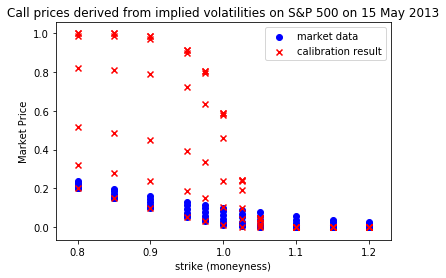

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(BSprice_toplot['strike'], 
           BSprice_toplot['price'], marker='o', color='b', label = 'market data')

ax.scatter(call_prices_df_toplot['strike'], 
           call_prices_df_toplot['price'], marker='x', color='r', label = 'calibration result')

ax.set(xlabel='strike (moneyness)', ylabel='Market Price', 
       title='Call prices derived from implied volatilities on S&P 500 on 15 May 2013')

ax.legend()


In [47]:
#prices derived from implied volatilities, assuming S0 = 1 and r = q = 0

MKTiv = '''
18.265 17.034 20.711 22.122 21.609 21.524 21.699
18.265 17.014 20.355 19.878 20.083 20.285 20.646
18.265 17.475 17.873 17.878 18.636 19.117 19.656
14.812 14.898 15.328 16.047 17.288 18.03 18.735
12.929 13.424 14.141 15.205 16.664 17.522 18.305
11.439 12.206 13.123 14.445 16.075 17.042 17.897
10.719 11.401 12.341 13.787 15.526 16.595 17.511
10.918 11.103 11.859 13.259 15.033 16.18 17.147
12.721 11.643 12.001 12.661 14.219 15.457 16.499
12.794 11.397 13.357 12.69 13.67 14.895 15.953
12.794 11.445 13.323 13.337 13.417 14.5 15.512
'''
MKTiv = MKTiv.replace('\n',' ').split(' ')[1:-1]

MKTiv = pd.DataFrame(np.array(MKTiv).reshape(11,7).T,
             index = ['1 month','2 months','3 months', '6 months', '1 year', '1.5 years', '2 years'] ,
   columns=['80%', '85%', '90%','95%','97.5%','100%', '102.50%','105%','110%','115%','120%'])

In [48]:
MKTiv

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 month,18.265,18.265,18.265,14.812,12.929,11.439,10.719,10.918,12.721,12.794,12.794
2 months,17.034,17.014,17.475,14.898,13.424,12.206,11.401,11.103,11.643,11.397,11.445
3 months,20.711,20.355,17.873,15.328,14.141,13.123,12.341,11.859,12.001,13.357,13.323
6 months,22.122,19.878,17.878,16.047,15.205,14.445,13.787,13.259,12.661,12.69,13.337
1 year,21.609,20.083,18.636,17.288,16.664,16.075,15.526,15.033,14.219,13.67,13.417
1.5 years,21.524,20.285,19.117,18.03,17.522,17.042,16.595,16.18,15.457,14.895,14.5
2 years,21.699,20.646,19.656,18.735,18.305,17.897,17.511,17.147,16.499,15.953,15.512


In [49]:
MKTiv_toplot = MKTiv
MKTiv_toplot.index = [1/12,2/12,3/12,6/12,12/12,18/12,24/12]
MKTiv_toplot.columns =[.8, .85, .9,.95,.975,1, 
                                   1.025, 1.05, 1.10 , 1.15 ,1.20]
MKTiv_toplot = MKTiv_toplot.astype('float')
MKTiv_toplot = unpivot(MKTiv_toplot)
MKTiv_toplot.columns = ['time to maturity', 'strike', 'IV']

In [50]:
BSprice_toplot.head()

,time to maturity,strike,price
0,0.083333,0.8,0.2000
1,0.166667,0.8,0.2000
2,0.250000,0.8,0.2005
3,0.500000,0.8,0.2048
4,1.000000,0.8,0.2151


Text(0.5, 0.92, 'Market IV')

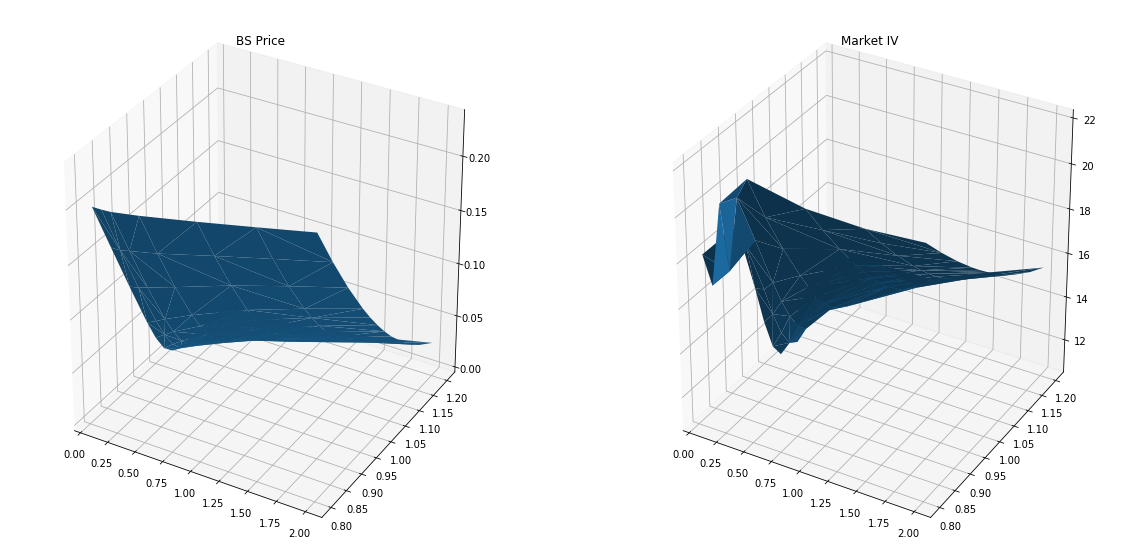

In [55]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(BSprice_toplot['time to maturity'], 
                 BSprice_toplot['strike'], 
                 BSprice_toplot['price'])
ax1.set_title('BS Price')


ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(MKTiv_toplot['time to maturity'], 
                 MKTiv_toplot['strike'], 
                 MKTiv_toplot['IV'])
ax2.set_title('Market IV')

In [24]:
df_toplot = BSprice.iloc[:, ::-1]
name_plot = 'Market BS Price'
t2m_name = [str(round(x, 2)) for x in list(df_toplot.index)]
strikes_name = [str(x) for x in list(df_toplot.columns)]
fig = go.Figure(data=[go.Surface(z=df_toplot.values)])

# fig.update_yaxes(ticks= 'outside', ticktext=list(BSprice.index), tickvals=[0,1,2,3,4,5])
fig.update(layout={'title':name_plot,
                   'scene':{
                       'yaxis':{
                           'title':'time to maturity',
                           'nticks': len(t2m_name),
                           'tickvals': list(range(len(t2m_name))),
                           'ticktext':t2m_name},
                       'xaxis':{
                           'title':'strikes (moneyness)',
                           'nticks': len(strikes_name),
                           'tickvals': list(range(len(strikes_name))),
                           'ticktext':strikes_name}, 
                      'zaxis':{
                           'title':'Market Price',
                           }}})
iplot(fig)

In [25]:
df_toplot = MKTiv.iloc[:, ::-1]
name_plot = 'Market IV'
t2m_name = [str(round(x, 2)) for x in list(df_toplot.index)]
strikes_name = [str(x) for x in list(df_toplot.columns)]
fig = go.Figure(data=[go.Surface(z=df_toplot.values)])

# fig.update_yaxes(ticks= 'outside', ticktext=list(BSprice.index), tickvals=[0,1,2,3,4,5])
fig.update(layout={'title':name_plot,
                   'scene':{
                       'yaxis':{
                           'title':'time to maturity',
                           'nticks': len(t2m_name),
                           'tickvals': list(range(len(t2m_name))),
                           'ticktext':t2m_name},
                       'xaxis':{
                           'title':'strikes (moneyness)',
                           'nticks': len(strikes_name),
                           'tickvals': list(range(len(strikes_name))),
                           'ticktext':strikes_name}, 
                      'zaxis':{
                           'title':'Market Price',
                           }}})
iplot(fig)

In [75]:
18.265 17.034 20.711 22.122 21.609 21.524 21.699
18.265 17.014 20.355 19.878 20.083 20.285 20.646
18.265 17.475 17.873 17.878 18.636 19.117 19.656
14.812 14.898 15.328 16.047 17.288 18.03 18.735
12.929 13.424 14.141 15.205 16.664 17.522 18.305
11.439 12.206 13.123 14.445 16.075 17.042 17.897
10.719 11.401 12.341 13.787 15.526 16.595 17.511
10.918 11.103 11.859 13.259 15.033 16.18 17.147
12.721 11.643 12.001 12.661 14.219 15.457 16.499
12.794 11.397 13.357 12.69 13.67 14.895 15.953
12.794 11.445 13.323 13.337 13.417 14.5 15.512

,80%,85%,90%,95%,97.5%,100%,102.50%,105%,110%,115%,120%
1 month,18.265,19.878,18.265,16.047,12.929,11.439,10.719,10.918,12.721,12.794,12.794
2 months,18.265,21.609,14.812,18.636,13.424,12.206,11.401,11.103,11.643,11.397,11.445
3 months,17.034,20.083,17.475,17.288,14.141,13.123,12.341,11.859,12.001,13.357,13.323
6 months,17.014,21.524,14.898,19.117,15.205,14.445,13.787,13.259,12.661,12.69,13.337
1 year,20.711,20.285,17.873,18.03,16.664,16.075,15.526,15.033,14.219,13.67,13.417
1.5 years,20.355,21.699,15.328,19.656,17.522,17.042,16.595,16.18,15.457,14.895,14.5
2 years,22.122,20.646,17.878,18.735,18.305,17.897,17.511,17.147,16.499,15.953,15.512
